In [1]:
!pip install numpy
!pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import hw1_class as cs
import readfile 
import time
import matplotlib.pyplot as plt

In [3]:
# readfile
documents = readfile.read_json_files('attachments')

In [4]:
# parameters
k = 10
num_permutations = 100
num_bands = 20
rows_per_band = 5
similarity_threshold = 0.5

In [5]:
# shingling and generate vocabulary
shingler = cs.Shingling(k)
shingles_list = [shingler.shingle(doc) for doc in documents]
vocas = shingler.vocas_from_documents(*documents)

In [6]:
# Calculate the jaccard similarity 
j_similarity = list()
for i in range(len(shingles_list)):
    for j in range (i + 1, len(shingles_list)): 
        similarity = cs.CompareSets.jaccard_similarity(set(shingles_list[i]), set(shingles_list[j]))
        print(f"Documents {i+1} and {j+1} are similar with Jaccard similarity {similarity}")
        if j == 12:
            j_similarity.append(similarity)

Documents 1 and 2 are similar with Jaccard similarity 0.010508097416244283
Documents 1 and 3 are similar with Jaccard similarity 0.014626635873749037
Documents 1 and 4 are similar with Jaccard similarity 0.010938692444670568
Documents 1 and 5 are similar with Jaccard similarity 0.008662350688428922
Documents 1 and 6 are similar with Jaccard similarity 0.016173752310536044
Documents 1 and 7 are similar with Jaccard similarity 0.012540971925324213
Documents 1 and 8 are similar with Jaccard similarity 0.010412494993992792
Documents 1 and 9 are similar with Jaccard similarity 0.012215946407460923
Documents 1 and 10 are similar with Jaccard similarity 0.019527896995708154
Documents 1 and 11 are similar with Jaccard similarity 0.018920166128287955
Documents 1 and 12 are similar with Jaccard similarity 0.01864951768488746
Documents 1 and 13 are similar with Jaccard similarity 0.013993541442411194
Documents 2 and 3 are similar with Jaccard similarity 0.021381986295715347
Documents 2 and 4 are 

In [7]:
# generate minhash signature
minhashing = cs.MinHashing(num_permutations, vocas)
signatures = {i: minhashing.compute_minhash_signature(shingles) for i, shingles in enumerate(shingles_list)}

In [8]:
# calculate min hash simlarity 
m_similarity = list()
for i in range(len(signatures)):
    for j in range (i + 1, len(signatures)): 
        similarity = cs.CompareSignatures.compute_signature_similarity(signatures[i], signatures[j])
        print(f"Documents {i+1} and {j+1} are similar with minHash similarity {similarity}")
        if j == 12:
            m_similarity.append(similarity)

Documents 1 and 2 are similar with minHash similarity 0.01
Documents 1 and 3 are similar with minHash similarity 0.02
Documents 1 and 4 are similar with minHash similarity 0.0
Documents 1 and 5 are similar with minHash similarity 0.01
Documents 1 and 6 are similar with minHash similarity 0.0
Documents 1 and 7 are similar with minHash similarity 0.02
Documents 1 and 8 are similar with minHash similarity 0.01
Documents 1 and 9 are similar with minHash similarity 0.05
Documents 1 and 10 are similar with minHash similarity 0.01
Documents 1 and 11 are similar with minHash similarity 0.0
Documents 1 and 12 are similar with minHash similarity 0.01
Documents 1 and 13 are similar with minHash similarity 0.0
Documents 2 and 3 are similar with minHash similarity 0.02
Documents 2 and 4 are similar with minHash similarity 0.01
Documents 2 and 5 are similar with minHash similarity 0.0
Documents 2 and 6 are similar with minHash similarity 0.01
Documents 2 and 7 are similar with minHash similarity 0.0

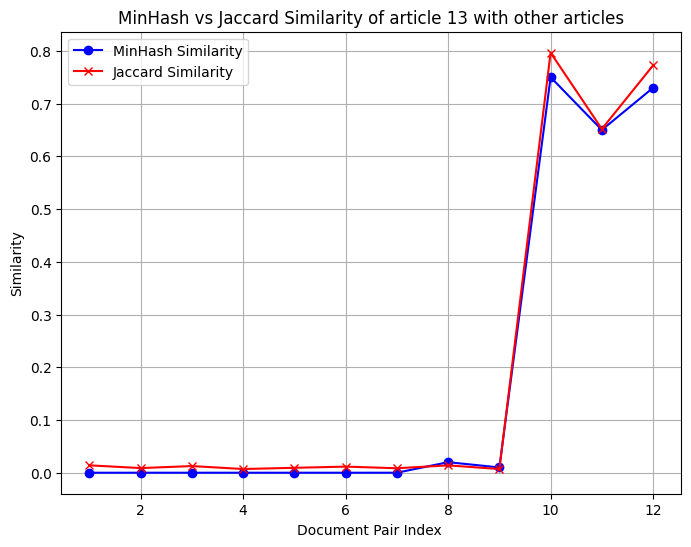

In [9]:
# show in a graph min hash vs jaccard similarity for the same document
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(m_similarity) + 1), m_similarity, label="MinHash Similarity", marker='o', linestyle='-', color='b')
plt.plot(range(1, len(j_similarity) + 1), j_similarity, label="Jaccard Similarity", marker='x', linestyle='-', color='r')
plt.title("MinHash vs Jaccard Similarity of article 13 with other articles")
plt.xlabel("Document Pair Index ")
plt.ylabel("Similarity")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

In [10]:
# lsh to find candidate pairs
lsh = cs.LSH(num_bands, rows_per_band)
candidate_pairs = lsh.find_candidate_pairs(signatures)

In [11]:
# show the jaccard similarity of candidate pairs
print("Candidate pairs:")

for pair in candidate_pairs:
    doc1, doc2 = pair
    jaccard_sim = cs.CompareSets.jaccard_similarity(set(shingles_list[doc1]), set(shingles_list[doc2]))
    # if jaccard_sim >= similarity_threshold:
    print(f"Documents {doc1} and {doc2} are similar with Jaccard similarity {jaccard_sim:.2f}") 

Candidate pairs:
Documents 9 and 10 are similar with Jaccard similarity 0.79
Documents 10 and 11 are similar with Jaccard similarity 0.77
Documents 9 and 12 are similar with Jaccard similarity 0.80
Documents 11 and 12 are similar with Jaccard similarity 0.77
Documents 9 and 11 are similar with Jaccard similarity 0.97
Documents 10 and 12 are similar with Jaccard similarity 0.65


In [12]:
# testing the scalability of our implementation

def test_scalability(documents, k, num_permutations, num_bands, rows_per_band):
    dataset_sizes = list(range(1, 13))
    execution_times = []

    for size in dataset_sizes:
        start_time = time.time()
        # Select subset of documents to test scalability
        subset_documents = documents[:size]

        # Shingling and generate vocabulary
        shingler = cs.Shingling(k)
        shingles_list = [shingler.shingle(doc) for doc in subset_documents]
        vocas = shingler.vocas_from_documents(*subset_documents)

        # Generate signature
        minhashing = cs.MinHashing(num_permutations, vocas)
        signatures = {i: minhashing.compute_minhash_signature(shingles) for i, shingles in enumerate(shingles_list)}

        # LSH
        lsh = cs.LSH(num_bands, rows_per_band)
        candidate_pairs = lsh.find_candidate_pairs(signatures)
        end_time = time.time()

        # Record execution time
        execution_times.append(end_time - start_time)

        # Optional: Print the result for a specific dataset size
        print(f"Dataset size: {size} | Execution time: {execution_times[-1]:.4f} seconds")

    return dataset_sizes, execution_times

Dataset size: 1 | Execution time: 0.1538 seconds
Dataset size: 2 | Execution time: 0.9744 seconds
Dataset size: 3 | Execution time: 4.2029 seconds
Dataset size: 4 | Execution time: 7.0931 seconds
Dataset size: 5 | Execution time: 12.6329 seconds
Dataset size: 6 | Execution time: 18.0100 seconds
Dataset size: 7 | Execution time: 21.8035 seconds
Dataset size: 8 | Execution time: 26.2282 seconds
Dataset size: 9 | Execution time: 31.0560 seconds
Dataset size: 10 | Execution time: 32.2578 seconds
Dataset size: 11 | Execution time: 35.1530 seconds
Dataset size: 12 | Execution time: 34.4869 seconds


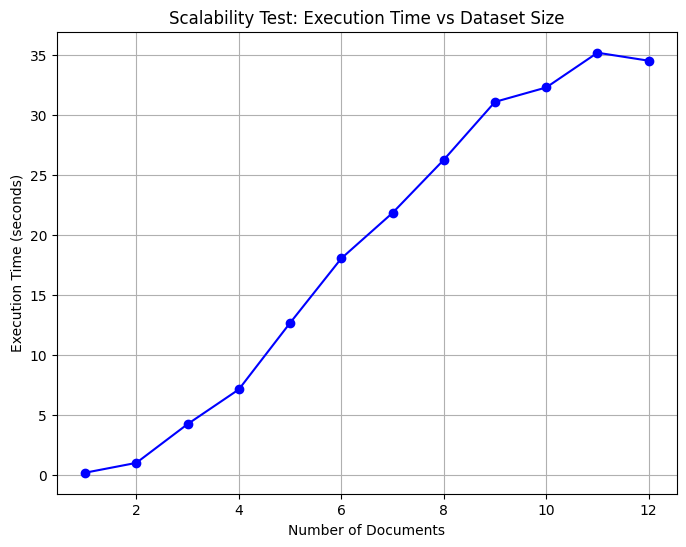

In [13]:
dataset_sizes, execution_times = test_scalability(documents, k, num_permutations, num_bands, rows_per_band)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(dataset_sizes, execution_times, marker='o', linestyle='-', color='b')
plt.title("Scalability Test: Execution Time vs Dataset Size")
plt.xlabel("Number of Documents")
plt.ylabel("Execution Time (seconds)")
plt.grid(True)
plt.show()